In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Load in data
df = pd.read_csv('zonnepanelen.csv') # Change this to the correct file path, preferably Zonnepanelen
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_slice = df[['timestamp', 'value']]
# Downsample the dataset
sampled = df_slice.set_index('timestamp').resample('30min').agg('first').fillna(0) # Change this to your preferred resample method
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(sampled)
print(scaled_data.shape)

#create scaled training data
train_length = int(round(scaled_data.shape[0]*0.8))
train_data = scaled_data[:train_length]
print(train_data.shape)
#split into x_train and y_train
x_train = []
y_train = []

n_lookback = 1 # How far we look back for each output, in this case 5 days
n_forecast = 240 # How far we forecast, in this case 5 days past the dataset

for i in range(n_lookback, len(train_data)):
    x_train.append(train_data[i-n_lookback:i])
    y_train.append(train_data[i])

#convert the x train and y train to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
#build lstm model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#train the model
model.fit(x_train, y_train, batch_size = 1, epochs=10)
test_data = scaled_data[train_length - n_lookback:]
x_test = []
for i in range(n_lookback, len(test_data)):
    x_test.append(test_data[i-n_lookback:i, 0])
#convert data to numpy array
x_test = np.array(x_test)
#reshape data
# %%
#get models predicted price
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# %%
#plot data
train_LSTM = sampled[:train_length]
valid_LSTM = sampled[train_length:]
valid_LSTM['Predictions'] = predictions
y_test = scaled_data[train_length:] # Only needed to test
MSE = np.square(np.subtract(y_test,predictions)).mean() 

RMSE = math.sqrt(MSE)
print("Root Mean Square Error: " + str(RMSE))

(483, 1)
(386, 1)
(385, 1, 1)
Epoch 1/10
385/385 [==============================] - 4s 4ms/step - loss: 0.0626
Epoch 2/10
385/385 [==============================] - 1s 4ms/step - loss: 0.0158
Epoch 3/10
385/385 [==============================] - 1s 4ms/step - loss: 0.0148
Epoch 4/10
385/385 [==============================] - 1s 4ms/step - loss: 0.0157
Epoch 5/10
385/385 [==============================] - 1s 4ms/step - loss: 0.0151
Epoch 6/10
385/385 [==============================] - 1s 4ms/step - loss: 0.0149
Epoch 7/10
385/385 [==============================] - 1s 4ms/step - loss: 0.0142
Epoch 8/10
385/385 [==============================] - 1s 4ms/step - loss: 0.0158
Epoch 9/10
385/385 [==============================] - 1s 4ms/step - loss: 0.0142
Epoch 10/10
385/385 [==============================] - 1s 4ms/step - loss: 0.0140
Root Mean Square Error: 9.808009691086667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


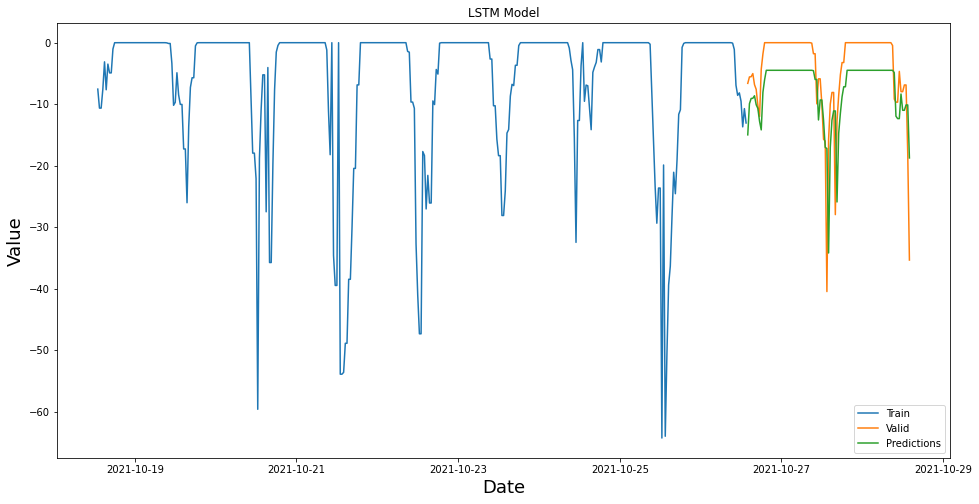

In [6]:
plt.figure(figsize = (16,8))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.plot(train_LSTM['value'])
plt.plot(valid_LSTM[['value','Predictions']])
plt.legend(['Train','Valid','Predictions'], loc='lower right')
plt.show()

In [7]:
# Create future dates
n_forecast = 48
add_dates = [sampled.index[-1] + pd.DateOffset(minutes=x*30) for x in range(0,n_forecast + 1) ]
future_dates = pd.DataFrame(index=add_dates[1:], columns = sampled.columns)
print(future_dates.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2021-10-28 14:30:00 to 2021-10-29 14:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   value   0 non-null      object
dtypes: object(1)
memory usage: 768.0+ bytes
None


In [8]:
# Creating future predictions
pred_list = []
print(train_data.shape)
batch = train_data[-n_lookback:].reshape((1, n_lookback, 1))
print(batch.shape)
for i in range(n_forecast):
  pred_list.append(model.predict(batch)[0]) # Generate the predictions
  batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

(386, 1)
(1, 1, 1)


In [9]:
# Combining dates and predictions
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_forecast:].index, columns=['Predictions'])

df_forecast = pd.concat([sampled, df_predict], axis=1)
print(df_forecast.tail(60))

                         value  Predictions
2021-10-28 08:30:00   0.000000          NaN
2021-10-28 09:00:00  -0.460000          NaN
2021-10-28 09:30:00  -9.176833          NaN
2021-10-28 10:00:00  -9.676334          NaN
2021-10-28 10:30:00  -9.676333          NaN
2021-10-28 11:00:00  -4.675500          NaN
2021-10-28 11:30:00  -7.966667          NaN
2021-10-28 12:00:00  -7.966667          NaN
2021-10-28 12:30:00  -6.878333          NaN
2021-10-28 13:00:00  -6.878333          NaN
2021-10-28 13:30:00 -18.022667          NaN
2021-10-28 14:00:00 -35.362000          NaN
2021-10-28 14:30:00        NaN   -14.992532
2021-10-28 15:00:00        NaN   -16.469243
2021-10-28 15:30:00        NaN   -17.586927
2021-10-28 16:00:00        NaN   -18.425463
2021-10-28 16:30:00        NaN   -19.050381
2021-10-28 17:00:00        NaN   -19.513758
2021-10-28 17:30:00        NaN   -19.856071
2021-10-28 18:00:00        NaN   -20.108231
2021-10-28 18:30:00        NaN   -20.293606
2021-10-28 19:00:00        NaN  

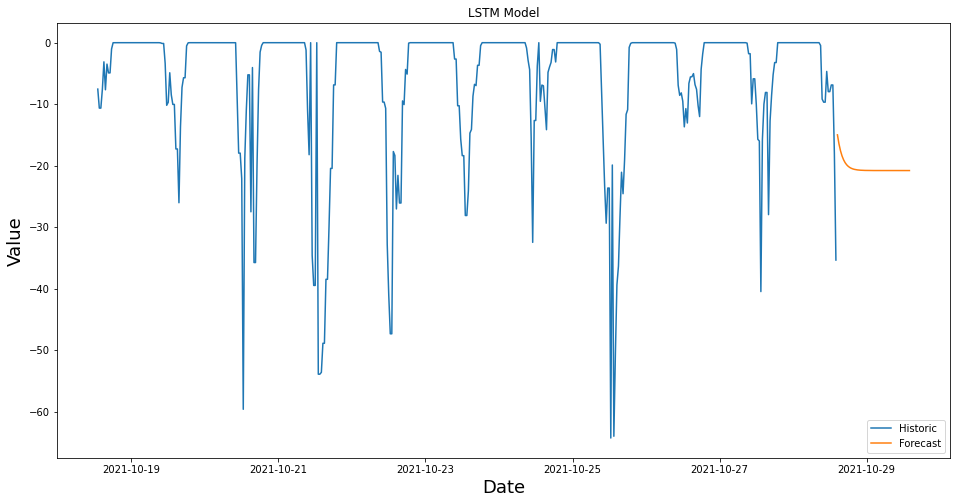

In [10]:
# Showing the future forecast
plt.figure(figsize = (16,8))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.plot(df_forecast[['value','Predictions']])
plt.legend(['Historic','Forecast'], loc='lower right')
plt.show()